# Calorimeter Energy Study

# 0. Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

from datetime import date
from datetime import datetime

import time
import os

---
# 1. Helper Functions

## 1.1. Load QDC and TDC from Text File
- `load_TQDC(finPath)`

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events

In [3]:
def load_TQDC(finPath):
    # basePath = "/media/sf_data/"
    # basePath = r'/media/eris/Sync1/sync/01_Research/MUSE/data'

    # load data from file
    # fin = os.path.join(basePath, finPath)
    fin = finPath
    t0 = time.time()
    raw_data = np.loadtxt(fin, skiprows = 5)
    t1 = time.time()
    print(f"Data file read in {t1-t0:.2f} seconds.")
    # return raw_data

    
    # initialize formatted data array
    num_events = raw_data.shape[0]
    print(f'There are {num_events} events')
    TDC = np.zeros((num_events, 8, 8), dtype=float)
    QDC = np.zeros((num_events, 8, 8), dtype=float)
    ogEventNums = np.zeros((num_events), dtype=int)
    
    
    # format data to [event#][x][y]
    t0 = time.time()
    i_event = -1

    
    for event in raw_data:
        i_event += 1 
        for x in range(8):
            # # this method preserves the original event number, but doesn't work when events aren't one by one
            # TDC [ np.int_(event[0]) ] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            # QDC [ np.int_(event[0]) ] [x] [:] = event[16*x+2 : 16*x+17 : 2]
            
            TDC [i_event] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            QDC [i_event] [x] [:] = event[16*x+2 : 16*x+17 : 2] 
            ogEventNums [i_event] = event[0]
            
    t1 = time.time()
    print(f"Data file formatted to array in {t1-t0:.2f} seconds.")
    
    return TDC, QDC, ogEventNums

## 1.2. Event Display
- `plotEvent(raw_data, event_num)`

In [4]:
colormap = 'magma'

def plotEvent(raw_data, event_num):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Plots an 8x8 histogram for the event
    '''
    
    TDC, QDC, ogEventNums = raw_data[:]
    
    ## 1. Plot Setup
    fig, (QAx, TAx) = plt.subplots(nrows=1, ncols=2, figsize= (13,5))#(11,4))
    plt.title(f'QDC for Event #{ogEventNums[event_num]}')

    ## 2. Plot QDC
    
    ## 2.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log10(np.where(QDC[event_num] <= 0, 0.01, QDC[event_num]))
    
    ## 2.2. Set flexible* max value for colorbar (*if the max qdc of this event is greater than the preset value, then use the actual max qdc value)
        # To cancel this effect, just set the preset value to be -1
                                                                                        # Format flexible vmax here
    presetMaxQDC = 3.5                                                                    
    if np.amax(thisFrame) > presetMaxQDC:
        this_vmax = np.amax(thisFrame)
    else:
        this_vmax = presetMaxQDC

    ## 2.3. Plot everything
    
    QPlot = QAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=this_vmax) # make sure to transpose frame for imshow
    
    QAx.set_title(f'QDC for Event #{ogEventNums[event_num]}')
    QAx.invert_yaxis()
    QAx.set_xticks(np.arange(0,8))
    Qcbar = plt.colorbar(QPlot, ax=QAx)
    Qcbar.set_label(r'QDC Counts ($\log_{10}$)', y=0.75)
    QAx.set_xlabel('X-coordinate of Bar')
    QAx.set_ylabel('Y-coordinate of Bar')
    # cbar.ax.tick_params()
   
    ## 2.4. Show QDC values in each square
    for x in range(8):
        for y in range(8):
            text = QAx.text(x, y, round(QDC[event_num][x][y],1), ha='center', va='center', color='w')
    
    ## 3. Plot TDC
    
    ## 3.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log(np.where(TDC[event_num] <= 0, 0.01, TDC[event_num]))
    
    ## 3.2. Plot everything 
    
    TPlot = TAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=5) # make sure to transpose frame for imshow
    
    TAx.set_title(f'TDC for Event #{ogEventNums[event_num]}')
    TAx.invert_yaxis()
    TAx.set_xticks(np.arange(0,8))
    Tcbar = plt.colorbar(TPlot, ax=TAx)
    Tcbar.set_label(r'TDC Counts ($\log_{10}$)', y=0.75)
    TAx.set_xlabel('X-coordinate of Bar')
    TAx.set_ylabel('Y-coordinate of Bar')
    
    ## 3.3. Show TDC values in each square
    for x in range(8):
        for y in range(8):
            if TDC[event_num][x][y] > 0.1:
                text = TAx.text(x, y, round(TDC[event_num][x][y],1), ha='center', va='center', color='w')

    
    fig.tight_layout()
    plt.show()
    return

## 1.3. Energy Sums
- `Esum1(raw_data, event_num, showStats=False, showEvent=False)`
- `Esum1_forall(raw_data)`
- `Esum2(raw_data, event_num, showStats=False, showHits=False)`
- `Esum2_forall(raw_data)`

In [5]:
def Esum1(raw_data, event_num, showStats=False, showEvent=False):
    '''
    Takes an 8x8 array of QDC values, finds the maximum value, and returns the sum of the max value + 8 surrounding values
    '''
    
    # Initial values/params
    _, QDC, ogEventNums = raw_data[:]
    frame = QDC[event_num]
    
    maxVal = np.amax(frame)
    maxPos = np.where(maxVal == frame)
    max_x = maxPos[0][0]
    max_y = maxPos[1][0]
    
    # Sum surrounding 8 voxels
    
    Esum = 0
    threshold = 0 # QDC values above this threshold will be added to the total Esum
    
    maxVal2 = 0
    E_total = 0
    
    for x in range(8):
        for y in range(8):
            if frame[x][y] >= threshold:
                E_total += frame[x][y]
            
            if abs(x-max_x) <= 1 and abs(y-max_y) <= 1 and frame[x][y] >= threshold:
                Esum += frame[x][y]
                
                if (x,y)!=(max_x,max_y) and frame[x][y] > maxVal2:
                    maxVal2 = frame[x][y]
                
    # Verbose output
    
    # avoid using this, it conflicts with showEvent functionality of esum2
    if showEvent: 
        plotEvent(raw_data,event_num)
        
    if showStats:
        print()
        print('******')
        print(f'{Esum:.2f}            = Energy sum (sum nonzero QDC values in max bar + 8 surrounding.')
        print('******')
        print()
        print(f'{maxVal:.2f} @ ({max_x},{max_y})    = Max QDC value @ (bar coordinate).')
        print()
        print(f'{maxVal / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar.')
        print(f'{(maxVal+maxVal2) / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar + 2nd highest QDC bar.')
        print(f'{Esum / E_total * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'Event #{ogEventNums[event_num]} (index {event_num})')

    
        # print(f'Sum of nonzero QDC values in 8 bars surrounding max bar          {Esum:.2f}')
        # print(f'Max QDC value and coordinate of bar                              {maxVal:.2f} @ ({max_x},{max_y})')
        # print(f'%Energy sum captured by central bar                              {maxVal / Esum * 100:.2f}%')
        # print(f'%Energy sum captured by central bar + 2nd highest QDC bar        {(maxVal+maxVal2) / Esum * 100:.2f}%.')
    
    return Esum #, [max_x, max_y]


def Esum1_forall(raw_data):
    # preallocate
    num_events = np.shape(raw_data[0]) [0]
    all_Esums = np.zeros(num_events, dtype=float)

    # calc values
    for event_num in range(num_events):
        all_Esums[event_num] = Esum1(raw_data, event_num)
        
    return all_Esums


################################################################################################################################################

def Esum2(raw_data, event_num, showStats=False, showHits=False):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Finds the total energy deposited by the scattering event by summing outliers, then subtracting the average non-outlier and subtracting it as noise
    '''
    
    _, QDC, ogEventNums = raw_data[:]
    
    ## 1. Find outliers and add to Esum
    frame = QDC[event_num]
    # frame = np.where(raw_data[1][event_num] < 0, 0, raw_data[1][event_num]) # If you replace negative values with 0, you tend to capture more voxels. Not sure if this is a good thing.
    
    q3, q1 = np.percentile(frame, [75, 25])
    iqr = q3 - q1
    outliers = np.where(frame > q3+1.5*iqr, True, False)
    
    Esum_noisy = np.sum(frame[outliers])
    
    ## 2. Find and subtract noise
    frame_zeroed = np.where(QDC[event_num] < 0, 0, QDC[event_num])
    avgNoise = np.average(frame_zeroed[np.invert(outliers)])
    
    numHits = np.sum(outliers)
    
    Esum = Esum_noisy - avgNoise * numHits

    # if Esum_noisy < 10:
    #     Esum_noisy, Esum = 0, 0
    
    
    # Verbose output
        
    if showStats:
        print()
        print('******')        
        print(f'{Esum:.2f}            = Energy sum (sum QDC values for \"hit\" bars)')
        print('******')
        print()
        print(f'{Esum_noisy:.2f}            = Noise corrected energy sum (subtract avg QDC of non-hit bars for each hit bar)')
        print()
        print(f'{ (Esum_noisy-Esum) / Esum:.2f}%             = Percent noise adjustment.')
        print(f'{Esum / (np.sum(frame_zeroed)) * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'Event #{ogEventNums[event_num]} (index {event_num})')

        
    if showHits:
        fig, ax = plt.subplots(figsize=(12,4.5))
        ax.imshow(outliers.T, 'magma')
        ax.invert_yaxis()
        ax.set_title(f'QDC \"Hits\" for Event #{ogEventNums[event_num]}')
        ax.set_xlabel('X-coordinate of Bar')
        ax.set_ylabel('Y-coordinate of Bar')
        plt.show()

        

    return Esum, Esum_noisy


def Esum2_forall(raw_data):
    # preallocate
    num_events = np.shape(raw_data[0]) [0]
    all_Esums = np.zeros(num_events, dtype=float)

    # calc values
    for event_num in range(num_events):
        all_Esums[event_num] = Esum2(raw_data, event_num)[0] # 0 for noise corrected, 1 for raw
        
    return all_Esums

## 1.4. Double Hit Events
- `removeDoubleHits(raw_data, TDC_threshold=1.0)`

In [6]:
def removeDoubleHits(raw_data, TDC_threshold=1.0):
    TDC_cut = []
    QDC_cut = []
    ogEventNum_cut = []
    
    TDC, QDC, ogEventNum = raw_data[:]
    total_num_events = np.shape(TDC)[0]
    num_double_events = 0

    for event_num in range(total_num_events):
        frame = TDC[event_num]

        maxVal = np.amax(frame)

        minVal = 0
        for x in range(8):
            for y in range(8):
                if frame[x][y] > minVal and frame[x][y] != maxVal:
                    minVal = frame[x][y]

        if maxVal - minVal > TDC_threshold and minVal > 1: # if this event has two hits
            num_double_events += 1
        else:
            TDC_cut.append(TDC[event_num])
            QDC_cut.append(QDC[event_num])
            ogEventNum_cut.append(ogEventNum[event_num])
    
    return [TDC_cut,QDC_cut,ogEventNum_cut]

## 1.5. Make Plots
- `makeIndividualPlots(arr, title)`
- `makeOverlaidPlots(arr1, arr2, label1, label2, title, path)`

In [7]:
def makeIndividualPlots(arr, title, path):
    fig, axs = plt.subplots(figsize=(10,7))

    y, x, _ = axs.hist(arr, bins=100)
    axs.set_yscale('log')
    axs.set_title(title)
    axs.set_xlabel('Energy Sum (QDC)')
    axs.set_ylabel('Counts (log10)')

    axs.legend(
        [f'Mean     = {np.mean(arr):.2f} \nStd Dev = {np.std(arr):.2f} \nEntries  = {len(arr)}'], 
        prop={'size': 12}
    )
    
    fig.savefig(path)
    plt.close(fig)
    
    max_channel = x[np.where(y == y.max())][0]
    
    return max_channel


def makeOverlaidPlots(arr1, arr2, label1, label2, title, path):
    fig, axs = plt.subplots(figsize=(10,7))

    axs.hist(arr1, 
            alpha=0.5, 
            bins=100, 
            label=label1)
    axs.hist(arr2, 
            alpha=0.5, 
            bins=100, 
            label=label2)
    
    
    axs.set_yscale('log')
    axs.set_title(title)
    axs.set_xlabel('Energy Sum (QDC)')
    axs.set_ylabel('Counts (log10)')
    axs.legend(loc='upper right')

    
    fig.savefig(path)
    plt.close(fig)
        
    return

---
# 2. Energy Study

In [7]:
# initialize run dict with filename and momentum

base = r'/media/eris/Sync1/sync/01_Research/MUSE/data/calorimeter/Elog2359/e-pid_bm_cut'
caloFiles = os.listdir(base)
elog2359_momenta = [230,210,190,170,160,150,130,110,90,70,50]

run = {}

for i in range(len(caloFiles)):
    run_num = int(caloFiles[i][3:8])
    run[run_num] = {}
    run[run_num]['filename'] = caloFiles[i]
    run[run_num]['momentum'] = elog2359_momenta[i]

In [8]:
# create plots folders

thisNotebookPath = r'/media/eris/Sync1/sync/01_Research/MUSE/repo/code/04_energyStudy'

x = date.today().strftime('%y%m%d')
y = datetime.now().strftime('%H%M')
z = f'plots__{x}_{y}'
folder1_plots = os.path.join(thisNotebookPath, z)
os.mkdir(folder1_plots)

In [9]:
plt.ioff() # turn off interactive plotting, only how with plt.show()

t0_all = time.time()

# i_run=12354
for i_run in run:


    print(f'Now processing run {i_run}')
    t0_run = time.time()

    # Load data
    print()
    raw_data = load_TQDC(os.path.join(base, run[i_run]['filename']))



    # Calculate energy sums on raw data
    t0 = time.time()
    Esum1_all = Esum1_forall(raw_data)
    t1 = time.time()
    print()
    print(f"Esum1 uncut took {t1-t0:.2f} seconds.")

    t0 = time.time()
    Esum2_all = Esum2_forall(raw_data)
    t1 = time.time()
    print(f"Esum2 uncut took {t1-t0:.2f} seconds.")



    # Remove double hits from data
    t0 = time.time()
    cut_data = removeDoubleHits(raw_data)
    t1 = time.time()
    print()
    x = (len(raw_data[0])-len(cut_data[0]))/len(raw_data[0])
    print(f'Percent of double hits in this dataset = {100*x:.2f}%')
    print(f"Removing double hits took {t1-t0:.2f} seconds.")




    # Calculate energy sums on cut data
    t0 = time.time()
    Esum1_all_cut = Esum1_forall(cut_data)
    t1 = time.time()
    print()
    print(f"Esum1 cut took {t1-t0:.2f} seconds.")

    t0 = time.time()
    Esum2_all_cut = Esum2_forall(cut_data)
    t1 = time.time()
    print(f"Esum2 cut took {t1-t0:.2f} seconds.")




    # Add stats
    run[i_run]['Esum1'] = {}

    run[i_run]['Esum1']['raw'] = {}
    run[i_run]['Esum1']['raw']['mean'] = np.mean(Esum1_all)
    run[i_run]['Esum1']['raw']['stddev'] = np.std(Esum1_all)
    run[i_run]['Esum1']['raw']['entries'] = len(Esum1_all)

    run[i_run]['Esum1']['DHcut'] = {}
    run[i_run]['Esum1']['DHcut']['mean'] = np.mean(Esum1_all_cut)
    run[i_run]['Esum1']['DHcut']['stddev'] = np.std(Esum1_all_cut)
    run[i_run]['Esum1']['DHcut']['entries'] = len(Esum1_all_cut)


    run[i_run]['Esum2'] = {}

    run[i_run]['Esum2']['raw'] = {}
    run[i_run]['Esum2']['raw']['mean'] = np.mean(Esum2_all)
    run[i_run]['Esum2']['raw']['stddev'] = np.std(Esum2_all)
    run[i_run]['Esum2']['raw']['entries'] = len(Esum2_all)

    run[i_run]['Esum2']['DHcut'] = {}
    run[i_run]['Esum2']['DHcut']['mean'] = np.mean(Esum2_all_cut)
    run[i_run]['Esum2']['DHcut']['stddev'] = np.std(Esum2_all_cut)
    run[i_run]['Esum2']['DHcut']['entries'] = len(Esum2_all_cut)


    t0 = time.time()

    # individual plots
    folder1x_runX = os.path.join(folder1_plots, f'run{i_run}')
    os.mkdir(folder1x_runX)

    max_channel = makeIndividualPlots(Esum1_all, f'Esum1 (raw)\nRun {i_run}', os.path.join(folder1x_runX, 'Esum1_raw.png'))
    run[i_run]['Esum1']['raw']['max_channel'] = max_channel

    max_channel = makeIndividualPlots(Esum2_all, f'Esum2 (raw)\nRun {i_run}', os.path.join(folder1x_runX, 'Esum2_raw.png'))
    run[i_run]['Esum2']['raw']['max_channel'] = max_channel

    max_channel = makeIndividualPlots(Esum1_all_cut, f'Esum1 (no double hits)\nRun {i_run}', os.path.join(folder1x_runX, 'Esum1_DHcut.png'))
    run[i_run]['Esum1']['DHcut']['max_channel'] = max_channel

    max_channel = makeIndividualPlots(Esum2_all_cut, f'Esum2 (no double hits)\nRun {i_run}', os.path.join(folder1x_runX, 'Esum2_DHcut.png'))
    run[i_run]['Esum2']['DHcut']['max_channel'] = max_channel



    # overlaid plots
    folder1x1_overlaid = os.path.join(folder1x_runX, 'overlaid')
    os.mkdir(folder1x1_overlaid)

    # makeOverlaidPlots(arr1, arr2, label1, label2, title, path)
    makeOverlaidPlots(Esum1_all, Esum2_all, 'Esum1', 'Esum2', f'Esum1 vs Esum2 (raw)\nRun {i_run}', os.path.join(folder1x1_overlaid, 'Esum1_v_Esum2_raw.png'))
    makeOverlaidPlots(Esum1_all_cut, Esum2_all_cut, 'Esum1', 'Esum2', f'Esum1 vs Esum2 (no double hits)\nRun {i_run}', os.path.join(folder1x1_overlaid, 'Esum1_v_Esum2_DHcut.png'))
    makeOverlaidPlots(Esum1_all, Esum1_all_cut, 'Raw', 'DHcut', f'(Esum1) Raw vs Double Hit Cut\nRun {i_run}', os.path.join(folder1x1_overlaid, 'Esum1_raw_vs_DHcut.png'))
    makeOverlaidPlots(Esum2_all, Esum2_all_cut, 'Raw', 'DHcut', f'(Esum2) Raw vs Double Hit Cut\nRun {i_run}', os.path.join(folder1x1_overlaid, 'Esum2_raw_vs_DHcut.png'))


    t1 = time.time()
    print()
    print(f"Made plots in {t1-t0:.2f} seconds.")

    t1_run = time.time()
    print()
    print()
    print(f"This run took {t1_run-t0_run:.2f} seconds.")



    print()
    print('------------------------------------------------------')
    print()

t1_all = time.time()
print()
print()
print(f"All runns took {t1_all-t0_all:.2f} seconds.")

Now processing run 12354

Data file read in 5.56 seconds.
There are 632746 events
Data file formatted to array in 6.68 seconds.

Esum1 uncut took 22.13 seconds.
Esum2 uncut took 68.97 seconds.

Percent of double hits in this dataset = 40.17%
Removing double hits took 12.12 seconds.

Esum1 cut took 16.54 seconds.
Esum2 cut took 45.91 seconds.

Made plots in 2.78 seconds.


This run took 180.74 seconds.

------------------------------------------------------

Now processing run 12355

Data file read in 6.81 seconds.
There are 675591 events
Data file formatted to array in 8.84 seconds.

Esum1 uncut took 27.60 seconds.
Esum2 uncut took 74.36 seconds.

Percent of double hits in this dataset = 28.65%
Removing double hits took 12.70 seconds.

Esum1 cut took 21.09 seconds.
Esum2 cut took 58.51 seconds.

Made plots in 2.35 seconds.


This run took 212.29 seconds.

------------------------------------------------------

Now processing run 12356

Data file read in 5.98 seconds.
There are 662635 e

In [10]:
# pretty display of dictionary
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

pretty(run)

12354
	filename
		run12354_calo_qdc_tdc.txt
	momentum
		230
	Esum1
		raw
			mean
				719.3290742802325
			stddev
				286.5790100018651
			entries
				632746
			max_channel
				617.7999040000001
		DHcut
			mean
				676.6655496815164
			stddev
				265.1447442451965
			entries
				378591
			max_channel
				617.7999040000001
	Esum2
		raw
			mean
				737.8012724071266
			stddev
				306.2944816942046
			entries
				632746
			max_channel
				601.2440457219227
		DHcut
			mean
				683.1894389455127
			stddev
				275.6407286338806
			entries
				378591
			max_channel
				606.9387669486773
12355
	filename
		run12355_calo_qdc_tdc.txt
	momentum
		210
	Esum1
		raw
			mean
				592.3621194627739
			stddev
				261.97581614285684
			entries
				675591
			max_channel
				448.7714512
		DHcut
			mean
				557.2182915643373
			stddev
				235.35815706706745
			entries
				482022
			max_channel
				475.5036094
	Esum2
		raw
			mean
				601.7621923352569
			stddev
				278.2223584987186
			entries
				675591
			m

In [11]:
# print the dictionary at the very end so i can save it later analysis -- to create as variable in another session, simply set variable equal to print output
print(run)

{12354: {'filename': 'run12354_calo_qdc_tdc.txt', 'momentum': 230, 'Esum1': {'raw': {'mean': 719.3290742802325, 'stddev': 286.5790100018651, 'entries': 632746, 'max_channel': 617.7999040000001}, 'DHcut': {'mean': 676.6655496815164, 'stddev': 265.1447442451965, 'entries': 378591, 'max_channel': 617.7999040000001}}, 'Esum2': {'raw': {'mean': 737.8012724071266, 'stddev': 306.2944816942046, 'entries': 632746, 'max_channel': 601.2440457219227}, 'DHcut': {'mean': 683.1894389455127, 'stddev': 275.6407286338806, 'entries': 378591, 'max_channel': 606.9387669486773}}}, 12355: {'filename': 'run12355_calo_qdc_tdc.txt', 'momentum': 210, 'Esum1': {'raw': {'mean': 592.3621194627739, 'stddev': 261.97581614285684, 'entries': 675591, 'max_channel': 448.7714512}, 'DHcut': {'mean': 557.2182915643373, 'stddev': 235.35815706706745, 'entries': 482022, 'max_channel': 475.5036094}}, 'Esum2': {'raw': {'mean': 601.7621923352569, 'stddev': 278.2223584987186, 'entries': 675591, 'max_channel': 444.8203622057387}, '

---
# 3. Momentum v Channel

In [8]:
run = {12354: {'filename': 'run12354_calo_qdc_tdc.txt', 'momentum': 230, 'Esum1': {'raw': {'mean': 719.3290742802325, 'stddev': 286.5790100018651, 'entries': 632746, 'max_channel': 617.7999040000001}, 'DHcut': {'mean': 676.6655496815164, 'stddev': 265.1447442451965, 'entries': 378591, 'max_channel': 617.7999040000001}}, 'Esum2': {'raw': {'mean': 737.8012724071266, 'stddev': 306.2944816942046, 'entries': 632746, 'max_channel': 601.2440457219227}, 'DHcut': {'mean': 683.1894389455127, 'stddev': 275.6407286338806, 'entries': 378591, 'max_channel': 606.9387669486773}}}, 12355: {'filename': 'run12355_calo_qdc_tdc.txt', 'momentum': 210, 'Esum1': {'raw': {'mean': 592.3621194627739, 'stddev': 261.97581614285684, 'entries': 675591, 'max_channel': 448.7714512}, 'DHcut': {'mean': 557.2182915643373, 'stddev': 235.35815706706745, 'entries': 482022, 'max_channel': 475.5036094}}, 'Esum2': {'raw': {'mean': 601.7621923352569, 'stddev': 278.2223584987186, 'entries': 675591, 'max_channel': 444.8203622057387}, 'DHcut': {'mean': 559.2222336697042, 'stddev': 244.98984519805745, 'entries': 482022, 'max_channel': 459.6824905478788}}}, 12356: {'filename': 'run12356_calo_qdc_tdc.txt', 'momentum': 190, 'Esum1': {'raw': {'mean': 491.90230448810433, 'stddev': 275.70917062796326, 'entries': 662635, 'max_channel': 324.18121140000005}, 'DHcut': {'mean': 453.4038974431532, 'stddev': 242.41904384887007, 'entries': 542291, 'max_channel': 321.3761601}}, 'Esum2': {'raw': {'mean': 495.98533405471244, 'stddev': 289.7926543439784, 'entries': 662635, 'max_channel': 303.29149972419276}, 'DHcut': {'mean': 453.05644225833265, 'stddev': 252.2248041664708, 'entries': 542291, 'max_channel': 306.9727964974315}}}, 12357: {'filename': 'run12357_calo_qdc_tdc.txt', 'momentum': 170, 'Esum1': {'raw': {'mean': 497.06738927128873, 'stddev': 328.84978067629436, 'entries': 548880, 'max_channel': 211.25180434999996}, 'DHcut': {'mean': 441.4010588107848, 'stddev': 300.5212731441026, 'entries': 442401, 'max_channel': 227.05821740000002}}, 'Esum2': {'raw': {'mean': 504.80762981573287, 'stddev': 344.40097121551906, 'entries': 548880, 'max_channel': 212.6250617120301}, 'DHcut': {'mean': 444.00025081810963, 'stddev': 312.51680187493116, 'entries': 442401, 'max_channel': 208.1114449357143}}}, 12358: {'filename': 'run12358_calo_qdc_tdc.txt', 'momentum': 160, 'Esum1': {'raw': {'mean': 582.7154400526214, 'stddev': 331.7475816675878, 'entries': 446302, 'max_channel': 191.58908554999996}, 'DHcut': {'mean': 521.6637589496435, 'stddev': 321.15586346817435, 'entries': 346111, 'max_channel': 190.1057768}}, 'Esum2': {'raw': {'mean': 595.1070592277736, 'stddev': 346.46353260543043, 'entries': 446302, 'max_channel': 183.70501628333332}, 'DHcut': {'mean': 528.36131512089, 'stddev': 333.66732310345213, 'entries': 346111, 'max_channel': 177.3932176772727}}}, 12359: {'filename': 'run12359_calo_qdc_tdc.txt', 'momentum': 150, 'Esum1': {'raw': {'mean': 642.0942503325222, 'stddev': 291.4059520583973, 'entries': 417476, 'max_channel': 830.6013087}, 'DHcut': {'mean': 591.0963762198841, 'stddev': 295.63246212298935, 'entries': 313788, 'max_channel': 274.5307363}}, 'Esum2': {'raw': {'mean': 657.8171199870521, 'stddev': 303.71103578937783, 'entries': 417476, 'max_channel': 863.9755447422006}, 'DHcut': {'mean': 601.2852639778938, 'stddev': 306.972002069205, 'entries': 313788, 'max_channel': 252.77707225345625}}}, 12360: {'filename': 'run12360_calo_qdc_tdc.txt', 'momentum': 130, 'Esum1': {'raw': {'mean': 668.6654965024753, 'stddev': 193.2968211765702, 'entries': 523210, 'max_channel': 724.33300175}, 'DHcut': {'mean': 647.2344953477199, 'stddev': 204.48103941563778, 'entries': 378250, 'max_channel': 706.9221235}}, 'Esum2': {'raw': {'mean': 688.0489879667933, 'stddev': 196.8848233584539, 'entries': 523210, 'max_channel': 718.5420968666666}, 'DHcut': {'mean': 662.0392914396198, 'stddev': 208.22234769376024, 'entries': 378250, 'max_channel': 718.5420968666666}}}, 12361: {'filename': 'run12361_calo_qdc_tdc.txt', 'momentum': 110, 'Esum1': {'raw': {'mean': 595.8498408476702, 'stddev': 115.894408222611, 'entries': 584744, 'max_channel': 592.5514132000001}, 'DHcut': {'mean': 587.7684156817455, 'stddev': 115.11948345547268, 'entries': 443164, 'max_channel': 592.5514132000001}}, 'Esum2': {'raw': {'mean': 613.1126052486316, 'stddev': 112.24535269211044, 'entries': 584744, 'max_channel': 602.0435510803384}, 'DHcut': {'mean': 601.764300978457, 'stddev': 110.89114798035277, 'entries': 443164, 'max_channel': 602.0435510803384}}}, 12362: {'filename': 'run12362_calo_qdc_tdc.txt', 'momentum': 90, 'Esum1': {'raw': {'mean': 479.46361728235775, 'stddev': 98.79033247314986, 'entries': 645039, 'max_channel': 480.96559905000004}, 'DHcut': {'mean': 472.4885206572113, 'stddev': 97.387201192035, 'entries': 539020, 'max_channel': 463.02791750000006}}, 'Esum2': {'raw': {'mean': 491.55903383178816, 'stddev': 95.9743460831883, 'entries': 645039, 'max_channel': 484.69882896539167}, 'DHcut': {'mean': 482.5379850815086, 'stddev': 93.87108584779982, 'entries': 539020, 'max_channel': 476.5350531845878}}}, 12363: {'filename': 'run12363_calo_qdc_tdc.txt', 'momentum': 70, 'Esum1': {'raw': {'mean': 367.4042796838766, 'stddev': 79.98214023068148, 'entries': 539441, 'max_channel': 365.04060435}, 'DHcut': {'mean': 363.36616177741354, 'stddev': 78.4255796792339, 'entries': 498148, 'max_channel': 365.04060435}}, 'Esum2': {'raw': {'mean': 373.9174386115249, 'stddev': 78.54615022267383, 'entries': 539441, 'max_channel': 365.04703167419353}, 'DHcut': {'mean': 368.9462621496087, 'stddev': 76.44025139701624, 'entries': 498148, 'max_channel': 365.04703167419353}}}}

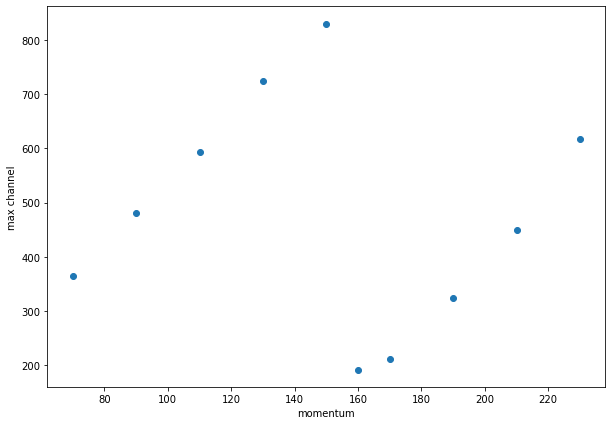

In [31]:
x = []
y = []

for i in run:
    x.append( run[i]['momentum'] )
    y.append( run[i]['Esum1']['raw']['max_channel'] )
    

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x,y)
ax.set_xlabel('momentum')
ax.set_ylabel('max channel')

plt.show(fig)

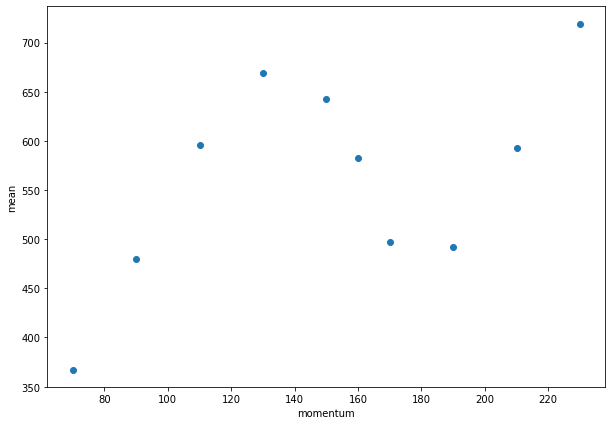

In [32]:
x = []
y = []

for i in run:
    x.append( run[i]['momentum'] )
    y.append( run[i]['Esum1']['raw']['mean'] )
    

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x,y)
ax.set_xlabel('momentum')
ax.set_ylabel('mean')

plt.show(fig)

---
# Misc

## Take a random sample of what I'm considering "double hits"

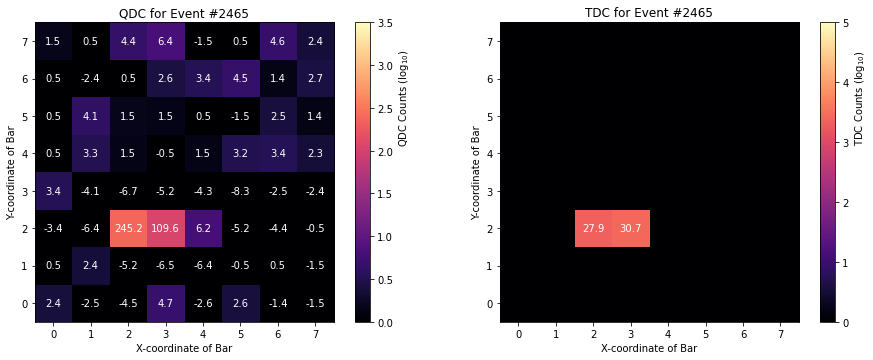

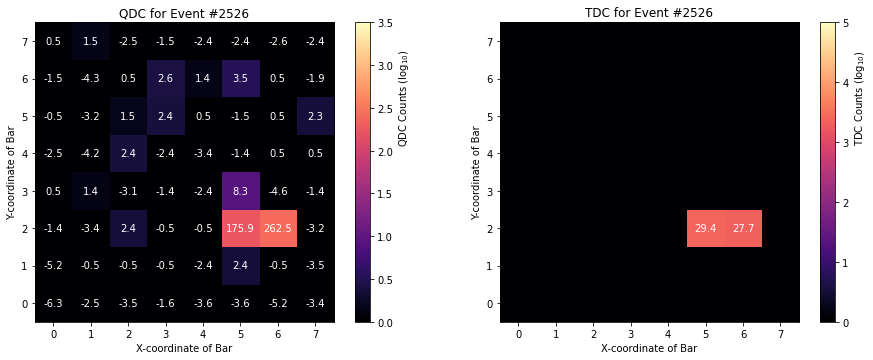

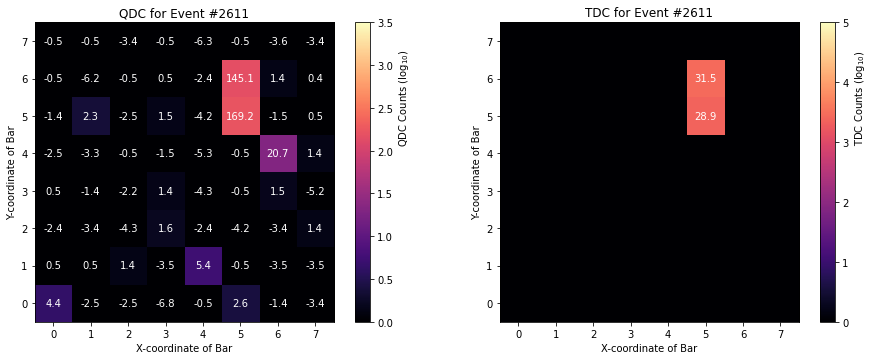

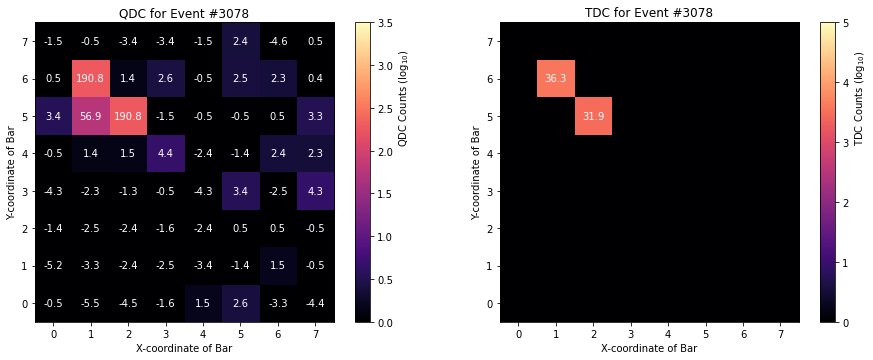

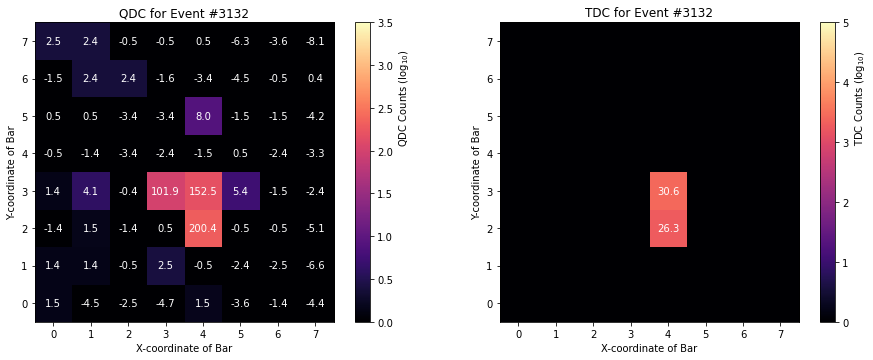

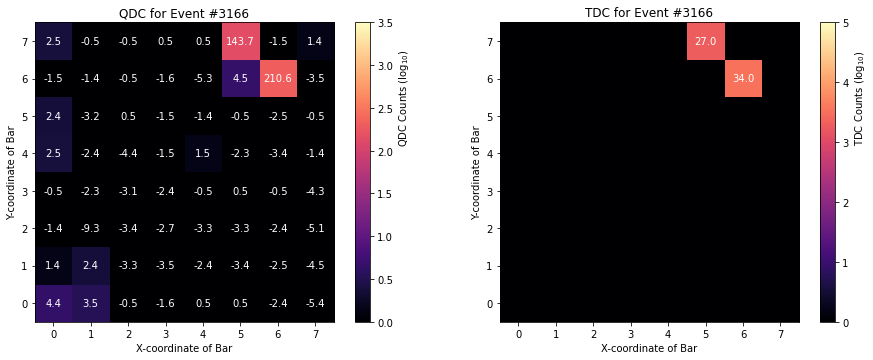

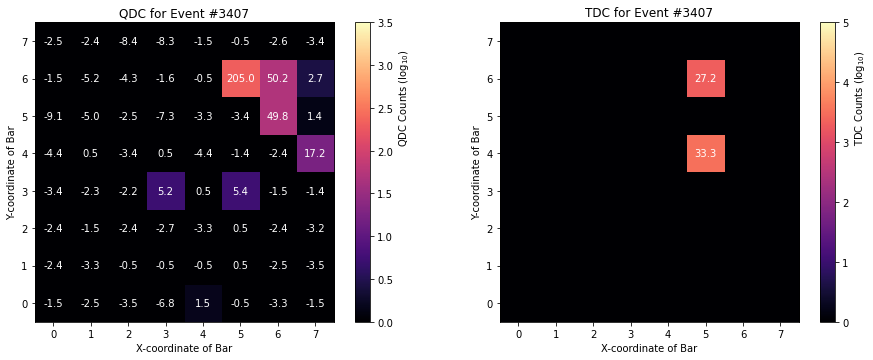

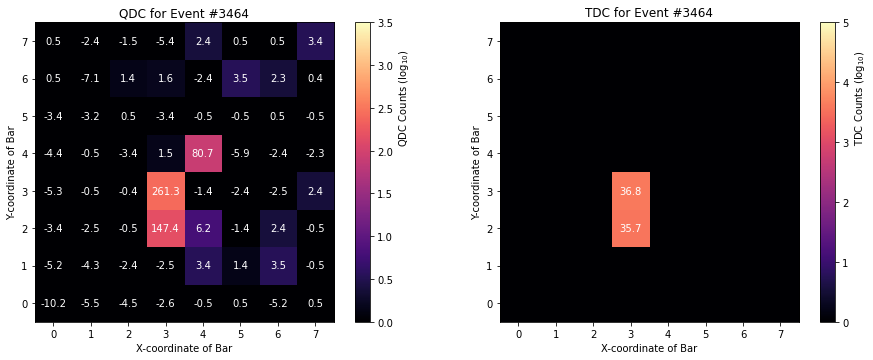

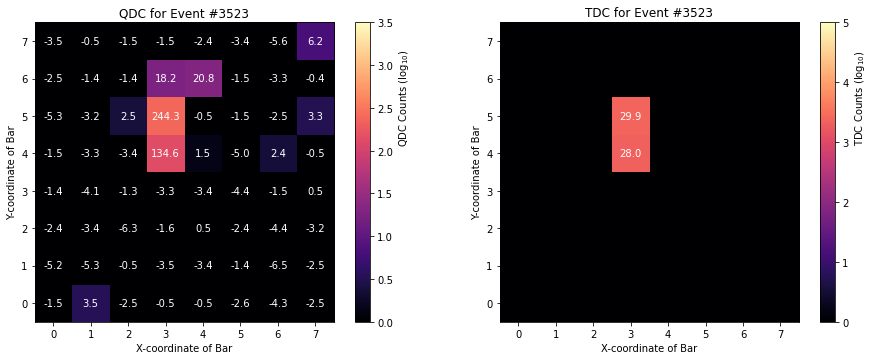

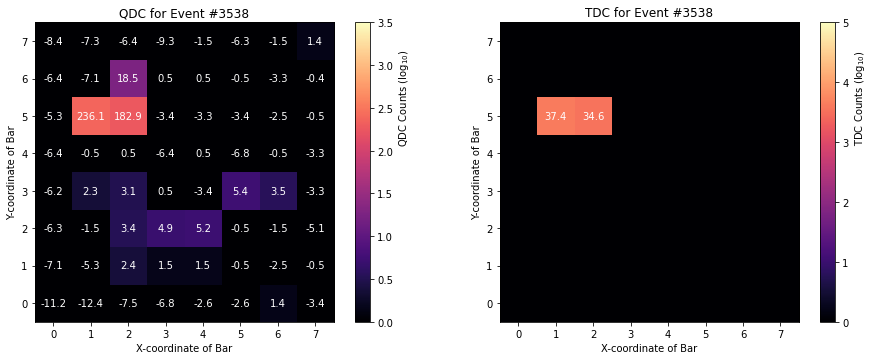

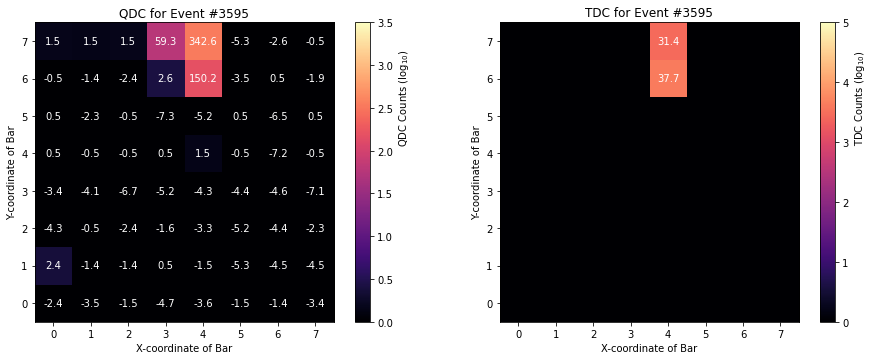

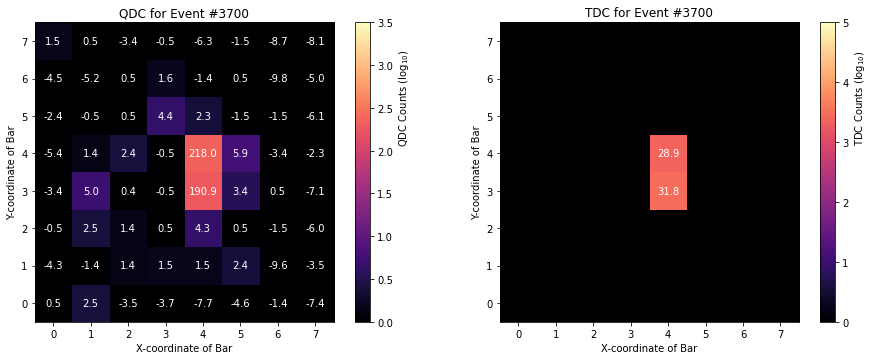

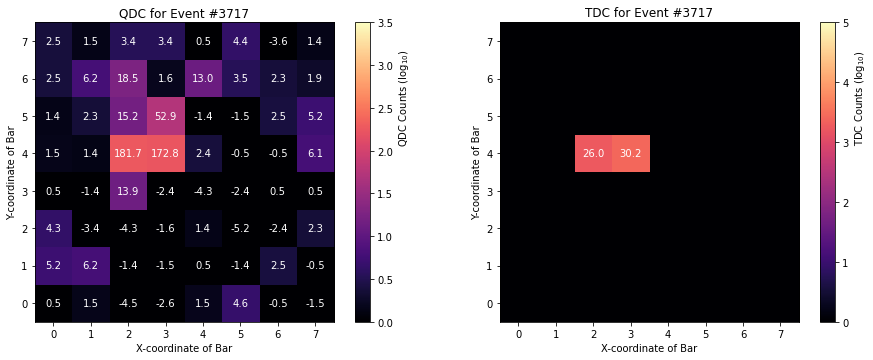

In [12]:
for i in range(1000,2000,10):
    if raw_data[2][i] not in cut_data[2]:
        plotEvent(raw_data, i)

In [13]:
test = {12354: {'filename': 'run12354_calo_qdc_tdc.txt', 'momentum': 230, 'Esum1': {'raw': {'mean': 719.3290742802325, 'stddev': 286.5790100018651, 'entries': 632746, 'max_channel': 617.7999040000001}, 'DHcut': {'mean': 676.6655496815164, 'stddev': 265.1447442451965, 'entries': 378591, 'max_channel': 617.7999040000001}}, 'Esum2': {'raw': {'mean': 737.8012724071266, 'stddev': 306.2944816942046, 'entries': 632746, 'max_channel': 601.2440457219227}, 'DHcut': {'mean': 683.1894389455127, 'stddev': 275.6407286338806, 'entries': 378591, 'max_channel': 606.9387669486773}}}, 12355: {'filename': 'run12355_calo_qdc_tdc.txt', 'momentum': 210, 'Esum1': {'raw': {'mean': 592.3621194627739, 'stddev': 261.97581614285684, 'entries': 675591, 'max_channel': 448.7714512}, 'DHcut': {'mean': 557.2182915643373, 'stddev': 235.35815706706745, 'entries': 482022, 'max_channel': 475.5036094}}, 'Esum2': {'raw': {'mean': 601.7621923352569, 'stddev': 278.2223584987186, 'entries': 675591, 'max_channel': 444.8203622057387}, 'DHcut': {'mean': 559.2222336697042, 'stddev': 244.98984519805745, 'entries': 482022, 'max_channel': 459.6824905478788}}}, 12356: {'filename': 'run12356_calo_qdc_tdc.txt', 'momentum': 190, 'Esum1': {'raw': {'mean': 491.90230448810433, 'stddev': 275.70917062796326, 'entries': 662635, 'max_channel': 324.18121140000005}, 'DHcut': {'mean': 453.4038974431532, 'stddev': 242.41904384887007, 'entries': 542291, 'max_channel': 321.3761601}}, 'Esum2': {'raw': {'mean': 495.98533405471244, 'stddev': 289.7926543439784, 'entries': 662635, 'max_channel': 303.29149972419276}, 'DHcut': {'mean': 453.05644225833265, 'stddev': 252.2248041664708, 'entries': 542291, 'max_channel': 306.9727964974315}}}, 12357: {'filename': 'run12357_calo_qdc_tdc.txt', 'momentum': 170, 'Esum1': {'raw': {'mean': 497.06738927128873, 'stddev': 328.84978067629436, 'entries': 548880, 'max_channel': 211.25180434999996}, 'DHcut': {'mean': 441.4010588107848, 'stddev': 300.5212731441026, 'entries': 442401, 'max_channel': 227.05821740000002}}, 'Esum2': {'raw': {'mean': 504.80762981573287, 'stddev': 344.40097121551906, 'entries': 548880, 'max_channel': 212.6250617120301}, 'DHcut': {'mean': 444.00025081810963, 'stddev': 312.51680187493116, 'entries': 442401, 'max_channel': 208.1114449357143}}}, 12358: {'filename': 'run12358_calo_qdc_tdc.txt', 'momentum': 160, 'Esum1': {'raw': {'mean': 582.7154400526214, 'stddev': 331.7475816675878, 'entries': 446302, 'max_channel': 191.58908554999996}, 'DHcut': {'mean': 521.6637589496435, 'stddev': 321.15586346817435, 'entries': 346111, 'max_channel': 190.1057768}}, 'Esum2': {'raw': {'mean': 595.1070592277736, 'stddev': 346.46353260543043, 'entries': 446302, 'max_channel': 183.70501628333332}, 'DHcut': {'mean': 528.36131512089, 'stddev': 333.66732310345213, 'entries': 346111, 'max_channel': 177.3932176772727}}}, 12359: {'filename': 'run12359_calo_qdc_tdc.txt', 'momentum': 150, 'Esum1': {'raw': {'mean': 642.0942503325222, 'stddev': 291.4059520583973, 'entries': 417476, 'max_channel': 830.6013087}, 'DHcut': {'mean': 591.0963762198841, 'stddev': 295.63246212298935, 'entries': 313788, 'max_channel': 274.5307363}}, 'Esum2': {'raw': {'mean': 657.8171199870521, 'stddev': 303.71103578937783, 'entries': 417476, 'max_channel': 863.9755447422006}, 'DHcut': {'mean': 601.2852639778938, 'stddev': 306.972002069205, 'entries': 313788, 'max_channel': 252.77707225345625}}}, 12360: {'filename': 'run12360_calo_qdc_tdc.txt', 'momentum': 130, 'Esum1': {'raw': {'mean': 668.6654965024753, 'stddev': 193.2968211765702, 'entries': 523210, 'max_channel': 724.33300175}, 'DHcut': {'mean': 647.2344953477199, 'stddev': 204.48103941563778, 'entries': 378250, 'max_channel': 706.9221235}}, 'Esum2': {'raw': {'mean': 688.0489879667933, 'stddev': 196.8848233584539, 'entries': 523210, 'max_channel': 718.5420968666666}, 'DHcut': {'mean': 662.0392914396198, 'stddev': 208.22234769376024, 'entries': 378250, 'max_channel': 718.5420968666666}}}, 12361: {'filename': 'run12361_calo_qdc_tdc.txt', 'momentum': 110, 'Esum1': {'raw': {'mean': 595.8498408476702, 'stddev': 115.894408222611, 'entries': 584744, 'max_channel': 592.5514132000001}, 'DHcut': {'mean': 587.7684156817455, 'stddev': 115.11948345547268, 'entries': 443164, 'max_channel': 592.5514132000001}}, 'Esum2': {'raw': {'mean': 613.1126052486316, 'stddev': 112.24535269211044, 'entries': 584744, 'max_channel': 602.0435510803384}, 'DHcut': {'mean': 601.764300978457, 'stddev': 110.89114798035277, 'entries': 443164, 'max_channel': 602.0435510803384}}}, 12362: {'filename': 'run12362_calo_qdc_tdc.txt', 'momentum': 90, 'Esum1': {'raw': {'mean': 479.46361728235775, 'stddev': 98.79033247314986, 'entries': 645039, 'max_channel': 480.96559905000004}, 'DHcut': {'mean': 472.4885206572113, 'stddev': 97.387201192035, 'entries': 539020, 'max_channel': 463.02791750000006}}, 'Esum2': {'raw': {'mean': 491.55903383178816, 'stddev': 95.9743460831883, 'entries': 645039, 'max_channel': 484.69882896539167}, 'DHcut': {'mean': 482.5379850815086, 'stddev': 93.87108584779982, 'entries': 539020, 'max_channel': 476.5350531845878}}}, 12363: {'filename': 'run12363_calo_qdc_tdc.txt', 'momentum': 70, 'Esum1': {'raw': {'mean': 367.4042796838766, 'stddev': 79.98214023068148, 'entries': 539441, 'max_channel': 365.04060435}, 'DHcut': {'mean': 363.36616177741354, 'stddev': 78.4255796792339, 'entries': 498148, 'max_channel': 365.04060435}}, 'Esum2': {'raw': {'mean': 373.9174386115249, 'stddev': 78.54615022267383, 'entries': 539441, 'max_channel': 365.04703167419353}, 'DHcut': {'mean': 368.9462621496087, 'stddev': 76.44025139701624, 'entries': 498148, 'max_channel': 365.04703167419353}}}}

In [14]:
test

{12354: {'filename': 'run12354_calo_qdc_tdc.txt',
  'momentum': 230,
  'Esum1': {'raw': {'mean': 719.3290742802325,
    'stddev': 286.5790100018651,
    'entries': 632746,
    'max_channel': 617.7999040000001},
   'DHcut': {'mean': 676.6655496815164,
    'stddev': 265.1447442451965,
    'entries': 378591,
    'max_channel': 617.7999040000001}},
  'Esum2': {'raw': {'mean': 737.8012724071266,
    'stddev': 306.2944816942046,
    'entries': 632746,
    'max_channel': 601.2440457219227},
   'DHcut': {'mean': 683.1894389455127,
    'stddev': 275.6407286338806,
    'entries': 378591,
    'max_channel': 606.9387669486773}}},
 12355: {'filename': 'run12355_calo_qdc_tdc.txt',
  'momentum': 210,
  'Esum1': {'raw': {'mean': 592.3621194627739,
    'stddev': 261.97581614285684,
    'entries': 675591,
    'max_channel': 448.7714512},
   'DHcut': {'mean': 557.2182915643373,
    'stddev': 235.35815706706745,
    'entries': 482022,
    'max_channel': 475.5036094}},
  'Esum2': {'raw': {'mean': 601.76219